#### Author: Ryan Coulsey

# Bonus Module: numba

In the coming labs you will begin opperating on large matricies and you will notice computation times increasing substantially. One solution to this problem is the threads library. The threads library solves one of two problems that the python functions you will be using have. Being able to run funtions in parallel will decrease computation times linearly with thread count, but will fail to solve the biggest problem with python: compilation time. 

# Compilation and numba

Numba decorators are refered to as 'just in time' compilers. Because python is a high level language that can dynamically assume data types, large portions of memory are allocated for each individual object in your code, and functions are compiled at the time they are called so that data typing can be assumed. In contrast, numba compiles a function the first time it is called with the data type it is passed, then opperates under the assumption that data types will not change in subsequent calls. This allows numba funtions to remain compiled to be called later.

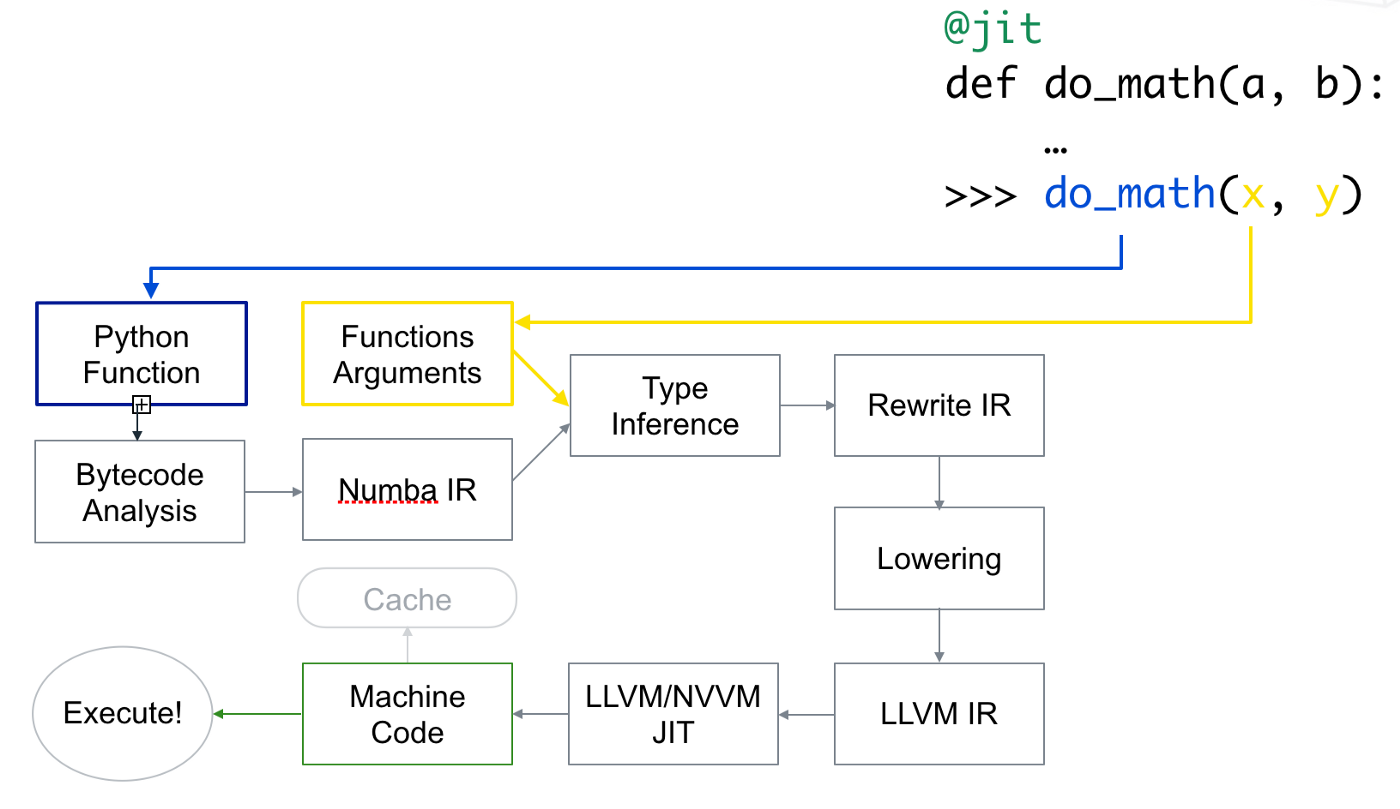

In [1]:
from numba import njit, prange, jit, stencil
import numpy as np
import matplotlib.pyplot as plt
from time import time
from multiprocessing import Pool
import multiprocessing as mp

## Linear Algebra

In Lab_03 you will be dealing with various algorithms that operate on matricies of varying sizes. As matrix size increases so does computation time. Using numba you can take advantage of for loops instead of fearing them and all their shortcomings in Python. 

Write about multipilcation here

### Matrix multiplication

In [ ]:
# Python realization of matrix multiplication
N = 500;M = 500
A = np.random.rand(M,N)
B = np.random.rand(N,M)
C = np.random.rand(M,M)

# direct implement
tic = time()
for i in range(M):
    for j in range(M):
        for k in range(N):
            C[i,j] += A[i,k]*B[k,j]
toc = time()
print('Direct implement O(n^3): {} s'.format(toc-tic))

# vectorization
# tic = time()
# for i in range(M):
#     for j in range(M):
#         C[i,j] = np.sum(A[i,:]*B[:,j])
# toc = time()
#print('Vectorization implement: {} s'.format(toc-tic))

# for package usage
# tic = time()
# C = A@B
# toc = time()
#print('Package implement: {} s'.format(toc-tic))

#numba njit

def Multiply(A, B, C):
    for i in range(M):
        for j in range(M):
            for k in range(N):
                C[i,j] += A[i,k]*B[k,j]
                
    return C

#VS

@njit
def njitMultiply(A, B, C):
    for i in range(M):
        for j in range(M):
            for k in range(N):
                C[i,j] += A[i,k]*B[k,j]
                
    return C



tic = time()
C = njitMultiply(A, B, C)
toc = time()
print('numba Direct implement O(n^3): {} s'.format(toc-tic))

@njit(parallel=True)
def njitMultiplyParr(A, B, C):
    for i in prange(M):
        for j in prange(M):
            for k in prange(N):
                C[i,j] += A[i,k]*B[k,j]
                
    return C

tic = time()
C = njitMultiplyParr(A, B, C)
toc = time()
print('numba Parallel implement O(n^3): {} s'.format(toc-tic))

In [ ]:
M = 5000

def MakePairs(M):
    A=np.zeros((M*M, 2))
    for i in range(M):
        for j in range(M):
            A[i] = [i, j]
            
    return A



tic = time()
C = MakePairs(M)
toc = time()
print('Direct implement O(n^2): {} s'.format(toc-tic))

@njit
def MakePairsJIT(M):
    A=np.zeros((M*M, 2))
    for i in range(M):
        for j in range(M):
            A[i] = [i, j]
            
    return A

tic = time()
C = MakePairsJIT(M)
toc = time()
print('Direct Numba implement O(n^2): {} s'.format(toc-tic))

@njit(parallel=True)
def MakePairsJITP(M):
    A=np.zeros((M*M, 2))
    for i in prange(M):
        for j in prange(M):
            A[i] = [i, j]
            
    return A

tic = time()
C = MakePairsJITP(M)
toc = time()
print('Parallel Numba implement O(n^2): {} s'.format(toc-tic))

As you can see, just applying an njit decorator to your direct implementation makes it about as fast as the Vecttorization implimentation. While this is interesting, and useful for you as a student trying not to think too hard about your code, it still doesn't achieve the speed of the naitive pakage implimentation. This is a place that numba will start to shine when calling functions repeatedly; you will see this later in the notebook

### Gausian Elimination

While gausian elimination is computationally expensive, and generally you should use other algorithms to solve linear systems, it is an incredible show of numba's potential to accelerate your code. 

In [2]:
mp.cpu_count()

12

In [ ]:
##Direct implimentation

def elimination(M):
    A = np.random.rand(M,M)
    tic = time()
    

    for i in range(M):
        for k in range(i+1, M):
            ratio = A[k][i]/A[i][i]
            for j in range(M):
                A[k][j] = A[k][j] - A[i][j]*ratio


    toc = time()
    return toc-tic


time0 = time()

if __name__ == "__main__":
    with Pool(12) as p:
        OAlg = p.map_async(elimination, range(10, 300, 10))
        OAlg.get()

time1 = time()

totalTime=time1-time0
totalPipe=np.sum(Oalg)

# for i in np.arange(10, 300, 10):
#     A, ttic, ttoc = elimination(i, i)
#     tic.append(ttic)
#     tok.append(ttoc)



plt.plot(np.arange(1, len(OAlg)+1), OAlg)
plt.ylabel('Computation Time (s)')
plt.xlabel('N/10')
plt.title('Computation times')
plt.show()

Adding an @njit decorator to this function will speed up the process significantly, but as you will see we can make our computation times even faster

In [ ]:
@njit
def elimination(M, N):
    A = np.random.rand(M,N)

    for i in range(M):
        for k in range(i+1, M):
            ratio = A[k][i]/A[i][i]
            for j in range(M):
                A[k][j] = A[k][j] - A[i][j]*ratio

    return A


tic = []
tok = []

for i in np.arange(10, 300, 10):
    ttic = time()
    A1 = elimination(i, i)
    ttoc = time()
    tic.append(ttic)
    tok.append(ttoc)


O = [tok[i] - tic[i] for i in range(len(tic))]
plt.plot(np.arange(2, len(O)+1), O[1:], label='JIT')
plt.plot(np.arange(1, len(O1)+1), O1, Label='Direct')
plt.legend()
plt.ylabel('Computation Time (s)')
plt.xlabel('N/10')
plt.title('Computation times')
plt.show()

By adding a parallel arguement to the njit operator we can spread the load this function produces to each logical thread in your CPU. There is one additional numba function that is important to the parallel option: prange(). Think of prange() as the range() function in an njit parallel function. There are right and wrong ways to use prange though, and we will go over these after an example of how to properly use the parallel njit decorator

In [ ]:
@njit(parallel=True)
def elimination(M, N):
    A = np.random.rand(M,N)

    for i in prange(M):
        ## Notice that the nested loop DOES NOT
        ## use the prange function and instead uses
        ## range.
        for k in range(i+1, M):
            ratio = A[k][i]/A[i][i]
            for j in range(M):
                A[k][j] = A[k][j] - A[i][j]*ratio
                

    return A


tic = []
tok = []

for i in np.arange(10, 300, 10):
    ttic = time()
    A1 = elimination(i, i)
    ttoc = time()
    tic.append(ttic)
    tok.append(ttoc)
    
O4 = [tok[i] - tic[i] for i in range(1, len(tic))]

In [ ]:
O3 = np.genfromtxt('GaussRes.txt', delimiter=',')
O1 = np.genfromtxt('GaussNPRes.txt', delimiter=',')
O2 = np.genfromtxt('GaussRe_naitives.txt', delimiter=',')
plt.plot(np.arange(2, len(O2)+1), O2[1:], label='Native', color='b')
#plt.plot(np.arange(2, len(O)+1), O[1:], label='Numba JIT', color='orange')
#plt.plot(np.arange(1, len(O4)+1), O4, Label='Numba JIT Parallel', color='g')
plt.plot(np.arange(1, len(O3)+1), O3, Label='pypy Compiled', color='r')
plt.plot(np.arange(1, len(O1)+1), O1, Label='pypy Compiled w/ interpretation', color='m')
plt.legend()
plt.ylabel('Computation Time (s)')
plt.xlabel('Matrix Size (N/10)')
plt.title('Computation times')
#plt.yscale('log')
plt.show()

## How NOT to use njit parallel decorators

While parallel functions are incredibly fast, you can introduce conditions where you will produce incorrect answers to functions. This usually comes from nesting prange loops. Only use prange on the outermost loop so everything else in the loop will be sequencial. This problem is hard to replicate, but if your function output ever seems off, in shape especially, go back and make sure that the nested loops are sequential after the first loop call. 

## njit and non-decorated functions 

If you do not use an njit decorater on a function and later call it in a decorated function, you will get an error code. Uncommend the following cell block if you would like to see this happen, then go ahead and decorate the function so that it runs properly. 

ctrl+/ will comment and uncomment multiple lines

In [ ]:

# def Gau1d(x, center, std):
#     Gau = np.exp(-(x-center)**2/((2*std**2)))
#     Const = 1/(std*np.sqrt(2*np.pi))
#     Gau = Const*Gau
#     #does not garuntee pdf
#     return Gau

# def Plot1d(x, fx, label=''):
#     plt.plot(x, fx)
#     plt.title(label)
#     plt.xlabel('x axis')
#     plt.ylabel("y axis")
#     plt.show()

# @njit
# def makeGauss():
#     x = np.linspace(0, 7, 100)
#     center = 5
#     std = 0.5
#     Gau = Gau1d(x, center, std)
#     return Gau

# Gau = makeGauss()
# Plot1d(np.linspace(0, 7, 100), Gau, label='Gaussian Plot')

## numba support for other libraries

Something you may have noticed if you tried to add a decorator to the Plot1d function in the last code block is that you got an error code. This is because numba only supports numpy functions up to this point, and does not recognize any other libraries. Even within numpy there are some functions with poor or no support. A notable and extremely relevent example of this is np.sum over multiple axis

In [ ]:
A = np.random.rand(300,200, 100)

# @njit
# def sumArrayonx(A):
#     B = np.sum(A, axis=(1, 2))
#     return B

# B = sumArrayonx(A)

@njit
def sumArrayonxCorrect(A):
    B = np.sum(A, axis=2)
    C = np.sum(B, axis=1)
    return C

C = sumArrayonxCorrect(A)

If you get an error code that points to a line of code that uses a function that is from an external library it is best to assume that the error is that numba does not support the function or the specific implimentation that you are trying to use.

## numba and data types

One of the biggest appeals of using python is the dynamic typing of variables. numba does not support this, and much like C, opperations cannot be handled with incompatible data types. A great example of this is the size atribute for some python classes. It returns a tuple that python can usually interpret as seperate numbers, but tubles play extremely poorly with numba. 

In [ ]:
U = np.random.rand(200, 200)

# @njit
# def makeZeroOfSameSize(U):
#     nx, ny = np.size(U, 0), np.size(U, 1)
#     C = np.zeros((nx, ny))
#     return C

# C = makeZeroOfSameSize(U)

@njit
def makeZeroOfSameSizeCorrect(U):
    nx, ny = len(U[:, 0]), len(U[0, :])
    C = np.zeros((nx, ny))
    return C

C = makeZeroOfSameSizeCorrect(U)

### Numba: lists and tupples

numba loves numpy arrays, and hates tupples and lists. Usually these arent a problem in python, but they will be in the numba compiled environment

In [ ]:
list1 = [1, 4, 5, 8]
list2 = [i for i in range(100)]

@njit
def ShowListBad(listn):
    evens = np.zeros(len(listn))
    for i in range(len(listn)):
        if listn[i]//1%2 == 0:
            evens[i] = 1
    return evens

evens1 = ShowListBad(list1)

While this code does run, it soon wont. Anything you write without explicitly declaring it an array leaves whether your code runs or not to chance. Instead, declare any array you pass to a numba function to be a numpy array

In [ ]:
list1 = [1, 4, 5, 8]
list2 = [i for i in range(100)]

@njit
def ShowList(listn):
    evens = np.zeros(len(listn))
    for i in range(len(listn)):
        if listn[i]//1%2 == 0:
            evens[i] = 1
    return evens

evens1 = ShowList(np.array(list1))

One final note on data types that is specific to scientific computing is overloading the int datatype with extremely large or small numbers. You can see an example of this below. You can change these values so that the int type is not being overloaded, and this will suppress the error code, but the function will just skip opperating on each element that overloads the dtype. If you try this, print the array after calling the function. The array will not have changed

In [ ]:
# X = np.arange(0, 10000, 1)

# @njit(parallel=True)
# def overload(x):
#     l = len(x)
#     for i in prange(l):
# #        x[i] = x[i]*2
#         x[i] = x[i]*3.6758*10**30
        
#     return x

# Y = overload(X)
# Y

## numba in object mode

If you have a very specific implimentation of a function that you don't know how to change to cooperate with the njit decorator, you can run your code slightly faster by using the @jit decorator. @njit is actually the same as calling @jit(nopython=True). The difference between the two though is that jit has 'object' mode, where EVERY python function will run with a significant penalty to speed. Sometimes though, it is worth using jit if you are using something like the scipy.linalg library or sklearn functions. These often have well writen and fairly novel functions in them and they are not worth replicating for the sake of speed.

In [ ]:
x = np.linspace(0, 100, 1000)
y = np.array([i*2 - 3 for i in range(1000)])

# @njit
# def notPlot(x, y):
#     plt.plot(x, y)
#     plt.title('This plot does not work')
#     plt.show()
    
# notPlot(x, y)

@jit
def notPlot(x, y):
    plt.plot(x, y)
    plt.title('This plot does work')
    plt.show()
    
notPlot(x, y)

jit mode does not run significantly faster than naitive python, so use it sparingly. It also makes your notebooks really ugly with all the warnings it will spit out. 

# Bonus section: @stencil

The @stencil decorator is an extremely useful and confusing decorator. It will automatically loop through an array with dynamic indexing and return the entire array without designated looping. Boundary conditions are assumed to be 0. An example will be more useful in explaining. 

Below is a simple algebraic smoothing algorythm that demonstrates the usecase of @stencil

In [ ]:
x = np.linspace(0, 100, 1000)
y = np.linspace(0, 100, 1000)
randArr = np.random.rand(len(x))

@njit(parallel=True)
def makeY(x, y, randArr):
    l = len(x)
    for i in prange(l):
        y[i] = x[i]*randArr[i]*0.1
        
    return y

yRand = makeY(x, y, randArr)

plt.plot(x, yRand)
plt.title('Rough graph')
plt.show()

@stencil
def makesmooth(y):
    return (1/7)*(y[-1]+y[0]+y[1]+y[-2]+y[2]+y[-3]+y[3])

smooth = makesmooth(yRand)

plt.plot(x, smooth)
plt.title('Smoothed Graph')
plt.show()

In [ ]:
plt.bar(x[1:], JSten, label='pypy')
plt.bar(x[1:], direct, label="Direct", tick_label=iters)

plt.legend()
plt.title('8th order AWE solver')
plt.ylabel("time")
plt.xlabel('number of iterations')
plt.show()

As you can see, if any index is out of range the value of that itteration will be suppressed to 0

# Closing

Numba is a powerful tool that you absolutelly should use in this class. Moving forward, computation times will increase greatly, and smarter implimentations will be necessary to getting things done on time. 

Numba is NOT a crutch though. Proper implimentation and efficient code should still be your main goal as you move through this course. Use numba to make fast code run faster, not to make poor code run 'in-time'

Finally,

#### Numba Loves:

arrays
for loops
numpy functions

#### Numba Hates:

lists and tuples
inconsistant data types
functions from librarys other that numpy

If standard python is a person that understands conversational english but moves at a brisk walking pace, then python with numba is a toddler that understands english to the level of a preschooler, but runs at olympic speeds.

Cheers, 
Ryan